# delaunay_simulation

> Simulate tension evolution and real space using Delaunay/Voronoi construction


In [ ]:
#| default_exp delaunay

In [ ]:
#| hide
from nbdev.showdoc import *
import nbdev

In [ ]:
#| export
from CE_simulation.triangle import *
from CE_simulation.tension import *

In [ ]:
#| export
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

from numpy import sin, cos, tan, pi, sqrt, arccos, arctan, arctan2
from numpy.linalg import norm

from scipy.stats import trim_mean

from scipy.integrate import solve_ivp
from scipy import ndimage
from scipy import spatial
from scipy import optimize

from tqdm.notebook import tqdm

from math import floor, ceil

import sys

from copy import deepcopy

In [ ]:
#| export

from dataclasses import dataclass
from typing import Union, Dict, List, Tuple, Iterable, Callable
from nptyping import NDArray, Int, Float, Shape

from fastcore.foundation import patch

## Delaunay simulation


Before we begin to code the optimization routines for the real space shape, here we simulate a mesh using the Delaunay/Voronoi duality.




In [ ]:
#| export

# geometric transform matrices

def rot_mat(theta):
    return np.array([[cos(theta), sin(theta)],[-sin(theta), cos(theta)]])

def shear_mat(s):
    return np.array([[s, 0],[0, 1/s]])

def scale_mat(s):
    return np.diag([s,s])

In [ ]:
#| export

def get_inertia(pts, q=0):
    """Pts = (n_points, 2). q=outlier removal"""
    pts -= trim_mean(pts,q, axis=0)
    x, y = pts.T
    Ixx = trim_mean(x**2, q)
    Ixy = trim_mean(x*y, q)
    Iyy = trim_mean(y**2, q)
    return np.array([[Ixx, Ixy], [Ixy,Iyy]])
    

In [ ]:
#| export

## Creating initial conditions - triangular lattice

def get_triangular_lattice_convex(nx, ny):

    assert nx%2

    y = np.arange(0, ny).astype(float)
    x = np.arange(nx)*sqrt(3)/2
    X, Y = np.meshgrid(x, y)
    Y = (Y+(np.arange(nx)%2)/2)
    X -= X.mean(); Y -=Y.mean()
    pts = np.stack([X, Y]).reshape((2,nx*ny))
    
    theta = 30
    thr = ceil(nx/4)
    halfplanes = [np.array([sin(pi/180*theta), cos(pi/180*theta)]),
                  np.array([sin(-pi/180*theta), cos(-pi/180*theta)])]
    vals = halfplanes[0].dot(pts)
    sorted_vals = np.sort(vals)
    is_convex = (vals > sorted_vals[thr]+1e-3) & (vals < sorted_vals[-(thr+1)]-1e-3)
    vals = halfplanes[1].dot(pts)
    sorted_vals = np.sort(vals)
    is_convex &= (vals > sorted_vals[thr]+1e-3) & (vals < sorted_vals[-(thr+1)]-1e-3)

    return pts[:, is_convex]

def get_triangular_lattice_convex_alt(nx, ny, convexify=True):

    assert ny%2 and nx%2 #and 2*ny > nx

    max_ny = 2*(nx-1)+1
    ny = min(ny, max_ny)
    
    y = np.arange(0, ny)*sqrt(3)/2
    x = np.arange(nx).astype(float)
    X, Y = np.meshgrid(x, y)

    X -= X.mean()+1/2; Y -=Y.mean()

    X = (X.T+(np.arange(ny)%2)/2).T
    pts = np.stack([X, Y]).reshape((2,nx*ny))
    
    theta = 60
    epsilon = 1e-4
    thr = floor(ny/4)
    halfplanes = [np.array([sin(pi/180*theta), cos(pi/180*theta)]),
                  np.array([sin(-pi/180*theta), cos(-pi/180*theta)])]
    vals = halfplanes[0].dot(pts)
    in_0_row = vals[np.abs(pts[1]) < epsilon]    
    is_convex = (vals > in_0_row.min()-epsilon) & (vals < in_0_row.max()+epsilon)
    
    vals = halfplanes[1].dot(pts)
    in_0_row = vals[np.abs(pts[1]) < epsilon]    
    is_convex &= (vals > in_0_row.min()-epsilon) & (vals < in_0_row.max()+epsilon)
    
    if convexify:
        pts = pts[:, is_convex]
        pts = (pts.T-pts.mean(axis=1)).T
        return pts
    return pts

def get_tri_hemesh(nx=7, ny=11, noise=0):
    pts = get_triangular_lattice_convex_alt(nx, ny)
    tri = spatial.Delaunay(pts.T)
    mesh = HalfEdgeMesh(ListOfVerticesAndFaces(tri.points, tri.simplices))
    mesh.transform_vertices(lambda x: x+np.random.normal(scale=noise, size=(2,)))
    return mesh

## Voronoi plotting

In [ ]:
#| export

from scipy.spatial._plotutils import _adjust_bounds
from matplotlib.collections import LineCollection

def voronoi_plot_2d_bdry(vor, bdry=None, plot_infinite=False, ax=None, **kw):
    """
    Plot the given Voronoi diagram in 2-D, with the possibility of leaving out bdries.
    "Forked" from github.com/scipy/scipy/blob/v1.9.1/scipy/spatial/_plotutils.py
    Parameters
    ----------
    vor : scipy.spatial.Voronoi instance
        Diagram to plot
    ax : matplotlib.axes.Axes instance, optional
        Axes to plot on
    show_points : bool, optional
        Add the Voronoi points to the plot.
    show_vertices : bool, optional
        Add the Voronoi vertices to the plot.
    line_colors : string, optional
        Specifies the line color for polygon boundaries
    line_width : float, optional
        Specifies the line width for polygon boundaries
    line_alpha : float, optional
        Specifies the line alpha for polygon boundaries
    point_size : float, optional
        Specifies the size of points
    plot_infinite : bool, optional
        plot edges to infinity
    Returns
    -------
    fig : matplotlib.figure.Figure instance
        Figure for the plot
    See Also
    --------
    Voronoi
    Notes
    -----
    Requires Matplotlib.
    Examples
    --------
    Set of point:
    >>> import matplotlib.pyplot as plt
    >>> rng = np.random.default_rng()
    >>> points = rng.random((10,2))
    Voronoi diagram of the points:
    >>> from scipy.spatial import Voronoi, voronoi_plot_2d
    >>> vor = Voronoi(points)
    using `voronoi_plot_2d` for visualisation:
    >>> fig = voronoi_plot_2d(vor)
    using `voronoi_plot_2d` for visualisation with enhancements:
    >>> fig = voronoi_plot_2d(vor, show_vertices=False, line_colors='orange',
    ...                 line_width=2, line_alpha=0.6, point_size=2)
    >>> plt.show()
    """
    if ax is None:
        fig = plt.figure()
        ax = fig.gca()
    bdry = [] if bdry is None else bdry
    if vor.points.shape[1] != 2:
        raise ValueError("Voronoi diagram is not 2-D")

    if kw.get('show_points', True):
        point_size = kw.get('point_size', None)
        ax.plot(vor.points[:,0], vor.points[:,1], '.', markersize=point_size)
    if kw.get('show_vertices', True):
        ax.plot(vor.vertices[:,0], vor.vertices[:,1], 'o')

    line_colors = kw.get('line_colors', 'k')
    line_width = kw.get('line_width', 1.0)
    line_alpha = kw.get('line_alpha', 1.0)

    center = vor.points.mean(axis=0)
    ptp_bound = vor.points.ptp(axis=0)

    finite_segments = []
    infinite_segments = []
    for pointidx, simplex in zip(vor.ridge_points, vor.ridge_vertices):
        simplex = np.asarray(simplex)
        if all([x in bdry for x in pointidx]):
            continue
        if np.all(simplex >= 0):
            finite_segments.append(vor.vertices[simplex])
        else:
            i = simplex[simplex >= 0][0]  # finite end Voronoi vertex

            t = vor.points[pointidx[1]] - vor.points[pointidx[0]]  # tangent
            t /= np.linalg.norm(t)
            n = np.array([-t[1], t[0]])  # normal

            midpoint = vor.points[pointidx].mean(axis=0)
            direction = np.sign(np.dot(midpoint - center, n)) * n
            if (vor.furthest_site):
                direction = -direction
            far_point = vor.vertices[i] + direction * ptp_bound.max()

            infinite_segments.append([vor.vertices[i], far_point])

    ax.add_collection(LineCollection(finite_segments,
                                     colors=line_colors,
                                     lw=line_width,
                                     alpha=line_alpha,
                                     linestyle='solid'))
    if plot_infinite:
        ax.add_collection(LineCollection(infinite_segments,
                                         colors=line_colors,
                                         lw=line_width,
                                         alpha=line_alpha,
                                         linestyle='dashed'))

    _adjust_bounds(ax, vor.points)

    return ax.figure

In [ ]:
#| export

@patch
def voronoiplot(self: HalfEdgeMesh, **kw):
    bdry_vertices = sorted([he._verticesid[0] for he in self.hes.values() if he.face is None])
    vertex_keys = sorted([key for key in self.vertices.keys()])

    pts = np.array([self.vertices[v].coords for v in vertex_keys])
    vor = spatial.Voronoi(pts, furthest_site=False)
    
    voronoi_plot_2d_bdry(vor, bdry=bdry_vertices, show_vertices=False, show_points=False)

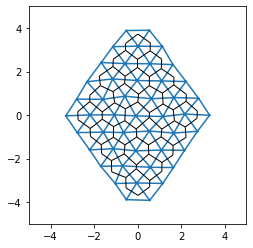

In [ ]:
mesh = get_tri_hemesh(noise=.05)
mesh.transform_vertices(shear_mat(s=1.1))
mesh.set_rest_lengths()

mesh.voronoiplot()
mesh.triplot()

plt.xlim([-5, 5])
plt.ylim([-5, 5])
plt.gca().set_aspect("equal", adjustable="box");

## Delaunay movie

In [ ]:
def temp_plot(msh):
    msh.voronoiplot()
    msh.triplot()
    #plt.title("initial")
    plt.xlim([-8, 8])
    plt.ylim([-7, 7])
    plt.gca().set_aspect("equal", adjustable="box");


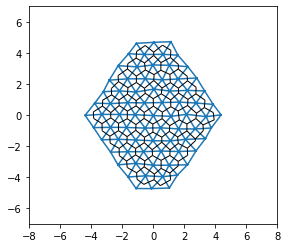

In [ ]:
mesh = get_tri_hemesh(nx=9, ny=13, noise=.05)
mesh.transform_vertices(shear_mat(s=1.1))
mesh.set_rest_lengths()

temp_plot(mesh)

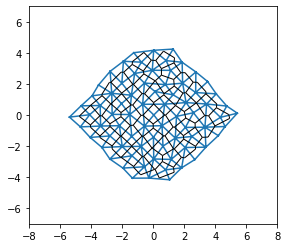

  0%|          | 0/10 [00:00<?, ?it/s]

0
flip


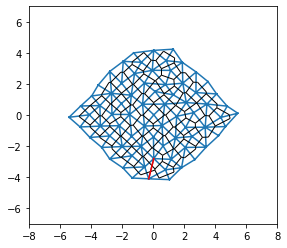

1
flip


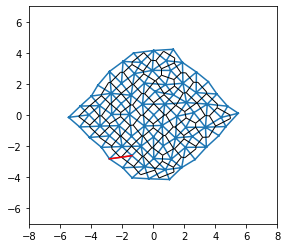

2
flip


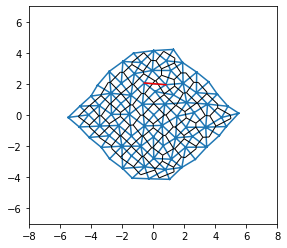

3
flip


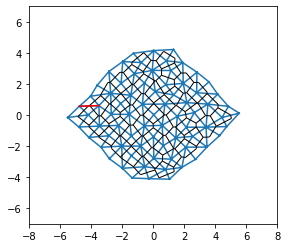

4
flip


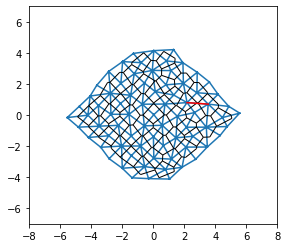

5
flip


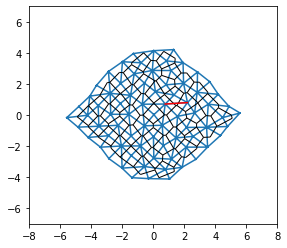

6
flip


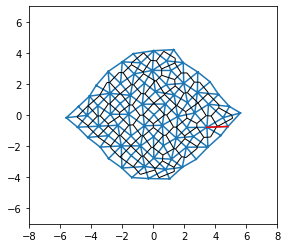

7
flip


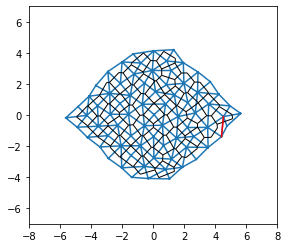

8
flip


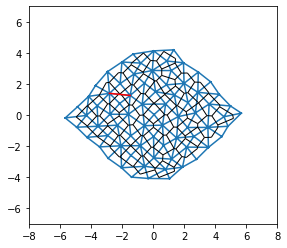

9
flip


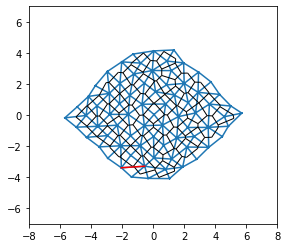

In [ ]:
#%%time

## simulate

m = 2
k = .25
dt = .005

meshes = [mesh]
times = [0]

temp_plot(mesh)
plt.savefig("plots/delaunay_frames/mesh_0000.png", dpi=300)
plt.show()
plt.close()

T1_count = [0]

for i in tqdm(range(10)):
    just_flipped = False # for plotting purposes
    print(i)
    # euler step
    for fc in mesh.faces.values():
        # collect edges
        Ts, Tps = (np.array([he.rest for he in fc.hes]), np.array([he.passive for he in fc.hes]))
        dT_dt, dTp_dt = excitable_dt_post(Ts, Tps, k=k, m=m)
        Ts += dt*dT_dt
        Tps += dt*dTp_dt
        for T, Tp, he in zip(Ts, Tps, fc.hes):
            he.rest = T
            he.passive = Tp
    # flatten
    get_E, grd = mesh.get_energy_fct()
    x0 = mesh.vertices_to_initial_cond()
    sol = optimize.minimize(get_E, x0, method="BFGS", jac=grd, tol=1e-3)
    if sol["status"] !=0:
        print(sol["message"])
        break
    new_coord_dict = mesh.initial_cond_to_vertices(sol["x"])
    for key, val in mesh.vertices.items():
        val.coords = new_coord_dict[key]
    mesh.set_rest_lengths()
    # compute angles and carry out an edge flip if required
    double_angles = mesh.get_double_angles()
    argmax = max(double_angles, key=double_angles.get)
    temp_plot(mesh)
    if double_angles[argmax] > 180 * (pi/180):        
        # resetting the active and passive tensions
        mesh.reset_rest_passive_flip(mesh.hes[argmax])
        try:
            just_flipped = True
            print("flip")
            # highlight flipped edge
            line = np.stack([mesh.hes[argmax].vertices[0].coords, mesh.hes[argmax].vertices[1].coords])
            plt.plot(*line.T, c="r")
            mesh.flip_edge(argmax)
            T1_count.append(T1_count[-1]+1)
        except ValueError:
            continue
    else:
        T1_count.append(T1_count[-1])
    #plt.savefig(f"plots/delaunay_frames/mesh_{str(i).zfill(4)}.png", dpi=300)
    if just_flipped:
        plt.show()
    plt.close()
    meshes.append(deepcopy(mesh))
    times.append(times[-1]+dt)

[<matplotlib.lines.Line2D>]

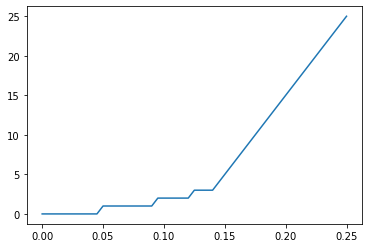

In [ ]:
plt.plot(times, T1_count)

In [ ]:
moments = np.stack([get_inertia(np.stack([v.coords for v in msh.vertices.values()])) for msh in meshes])

Text(0, 0.5, 'T1 count/Delaunay vertex')

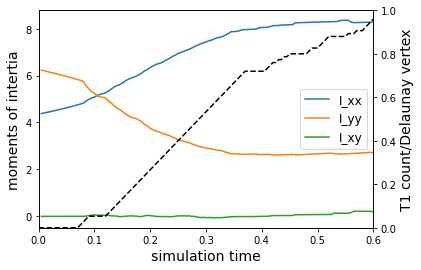

In [ ]:
#| notest

plt.plot(times[1:], moments[1:, 0,0], label="I_xx")
plt.plot(times[1:], moments[1:, 1,1], label="I_yy")
plt.plot(times[1:], moments[1:, 0,1], label="I_xy")
plt.xlim([0, times[120]])

plt.xlabel("simulation time", fontsize=14)
plt.ylabel("moments of intertia", fontsize=14)
plt.legend(fontsize=12)

plt.gca().twinx().plot(times, np.array(T1_count)/len(mesh.vertices.values()), color="k", ls="dashed")
plt.ylim([0, 1])
plt.ylabel("T1 count/Delaunay vertex", fontsize=14)


Text(0.5, 0, 'moments of intertia')

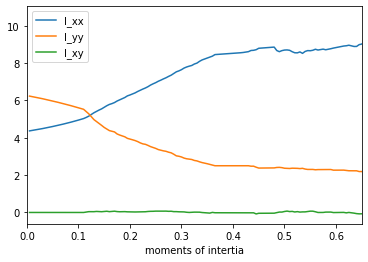

In [ ]:
#| notest

plt.plot(times[1:], moments[1:, 0,0], label="I_xx")
plt.plot(times[1:], moments[1:, 1,1], label="I_yy")
plt.plot(times[1:], moments[1:, 0,1], label="I_xy")
plt.legend()
plt.xlim([0, times[130]])

plt.xlabel("simulation time")
plt.xlabel("moments of intertia")

In [ ]:
np.abs(moments[:,0,1]).mean() / np.abs(moments[:,1,1]).mean()

0.018050381262640833

Movie rendered with 

`ffmpeg -framerate 10 -pattern_type glob -i '*.png' -c:v libx264 -pix_fmt yuv420p out.mp4`

Strange problem: last few frames don't make it into movie. Duplicate last frame bunch of times to fix.

## Package loop operations into functions 

In [ ]:
#| export

@patch
def flatten_triangulation(self: HalfEdgeMesh, tol=1e-3, verbose=True):
    """Flatten triangulation"""
    get_E, grd = self.get_energy_fct()
    x0 = self.vertices_to_initial_cond()
    sol = optimize.minimize(get_E, x0, method="CG", jac=grd, tol=tol)
    if sol["status"] !=0 and verbose:
        print("Triangulation optimization failed")
        print(sol["message"])
    new_coord_dict = self.initial_cond_to_vertices(sol["x"])
    for key, val in self.vertices.items():
        val.coords = new_coord_dict[key]
    self.set_rest_lengths()

@patch
def euler_step(self: HalfEdgeMesh, dt=.005, rhs=excitable_dt_post, params=None,
              rhs_rest_shape=None):
    """RHS: callable Ts, Tps -> dTs_dt, dTps_dt. Params can either be a dict of keyword args
    to the RHS function, or a callable faceid -> keyword dict.
    rhs_rest_shape: fc -> d_rest_shape_dt, for rest shape dynamics (e.g. viscous relaxation)
    """
    rhs_rest_shape = (lambda fc: 0) if rhs_rest_shape is None else rhs_rest_shape
    for fc in self.faces.values():
        # collect edges
        Ts, Tps = (np.array([he.rest for he in fc.hes]), np.array([he.passive for he in fc.hes]))
        if isinstance(params, dict):
            dT_dt, dTp_dt = excitable_dt_post(Ts, Tps, **params)
        elif callable(params):
            dT_dt, dTp_dt = excitable_dt_post(Ts, Tps, **params(fc._fid))
        Ts += dt*dT_dt
        Tps += dt*dTp_dt
        for T, Tp, he in zip(Ts, Tps, fc.hes):
            he.rest = T
            he.passive = Tp
        fc.rest_shape += dt*rhs_rest_shape(fc)


## Voronoi construction

In [ ]:
# we would still like to get the vornoi vertices and add them to the faces of the triangulation!

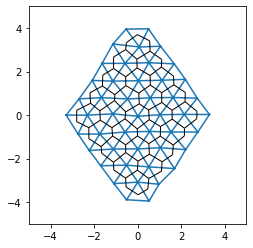

In [ ]:
mesh = get_tri_hemesh(noise=.05)
mesh.transform_vertices(shear_mat(s=1.1))
mesh.set_rest_lengths()

mesh.voronoiplot()
mesh.triplot()

plt.xlim([-5, 5])
plt.ylim([-5, 5])
plt.gca().set_aspect("equal", adjustable="box");

In [ ]:
vertex_keys = sorted([key for key in mesh.vertices.keys()])

pts = np.array([mesh.vertices[v].coords for v in vertex_keys])
vor = spatial.Voronoi(pts, furthest_site=False)

vor.points.shape, vor.vertices.shape # input points, voronoi vertices

# need to find out which voronoi vertex corresponds to which triangulation face. bookkeeping too painful
# actually this is far too painful. just do it myself.

((47, 2), (79, 2))

In [ ]:
#| export

def get_circumcenter(a, b, c):
    """Return circumcircle radius and circumcenter"""
    b_, c_ = (b-a, c-a)
    d_ = 2*(b_[0]*c_[1]-b_[1]*c_[0])
    u_ = np.array([c_[1]*(b_**2).sum()-b_[1]*(c_**2).sum(), b_[0]*(c_**2).sum()-c_[0]*(b_**2).sum()]) / d_
    r = norm(u_)
    return r, u_ + a

In [ ]:
mesh = get_tri_hemesh(noise=.05)
mesh.transform_vertices(shear_mat(s=1.05))
mesh.set_rest_lengths()

In [ ]:
#| export

def get_voronoi_pos(mesh):
    circumcenter_dict = {}
    for key, fc in mesh.faces.items():
        vecs = []
        returned = False
        start_he = fc.hes[0]
        he = start_he
        while not returned:
            vecs.append(he.vertices[0].coords)
            he = he.nxt
            returned = (he == start_he)
        _, circumcenter = get_circumcenter(*vecs)
        circumcenter_dict[key] = circumcenter
    return circumcenter_dict

@patch
def set_voronoi(self: HalfEdgeMesh):
    """Set dual positions to voronoi"""
    for fc in self.faces.values():
        vecs = []
        returned = False
        start_he = fc.hes[0]
        he = start_he
        while not returned:
            vecs.append(he.vertices[0].coords)
            he = he.nxt
            returned = (he == start_he)
        _, circumcenter = get_circumcenter(*vecs)
        fc.dual_coords = circumcenter

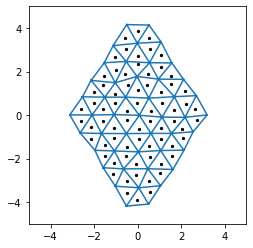

In [ ]:
circumcenter_dict = get_voronoi_pos(mesh)

for key, val in circumcenter_dict.items():
    plt.scatter(val[0], val[1], color="k", s=5)


mesh.triplot()

plt.xlim([-5, 5])
plt.ylim([-5, 5])
plt.gca().set_aspect("equal", adjustable="box");

In [ ]:
mesh.set_voronoi()